## Importing necessary libraries

In [ ]:
!pip install pyLDAvis==2.1.2

In [66]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
from tqdm import tqdm

from google.colab import drive 
import  os

import nltk
nltk.download("stopwords")
nltk.download("wordnet")
from nltk.corpus import stopwords

import gensim
import spacy
import logging
import warnings
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import pickle
import spacy
import ast
from spacy.lang.en import English

import pyLDAvis
import pyLDAvis.gensim
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors
from collections import Counter
from matplotlib.patches import Rectangle
from matplotlib.ticker import FuncFormatter

from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

%matplotlib inline
warnings.filterwarnings("ignore")
logging.basicConfig(format = '%(asctime)s : %(levelname)s : %(message)s', level = logging.ERROR)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
drive.mount("/content/drive")
os.chdir("/content/drive/MyDrive/Colab Notebooks/NLP/Topic Modeling Gensim")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Loading the data and data pre-preprocessing


In [4]:
df = pd.read_csv("bbc-text.csv")
df.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


In [5]:
df.text[0]

'tv future in the hands of viewers with home theatre systems  plasma high-definition tvs  and digital video recorders moving into the living room  the way people watch tv will be radically different in five years  time.  that is according to an expert panel which gathered at the annual consumer electronics show in las vegas to discuss how these new technologies will impact one of our favourite pastimes. with the us leading the trend  programmes and other content will be delivered to viewers via home networks  through cable  satellite  telecoms companies  and broadband service providers to front rooms and portable devices.  one of the most talked-about technologies of ces has been digital and personal video recorders (dvr and pvr). these set-top boxes  like the us s tivo and the uk s sky+ system  allow people to record  store  play  pause and forward wind tv programmes when they want.  essentially  the technology allows for much more personalised tv. they are also being built-in to high

In [6]:
df.shape

(2225, 2)

In [7]:
df.duplicated().sum()

99

In [8]:
df.drop_duplicates(inplace = True)

In [9]:
df.shape

(2126, 2)

In [10]:
stop_words = stopwords.words("english")
file = open("stopwords/extended_stopwords.txt", "r")
stop_words.extend([line.strip() for line in file.readlines()])
file.close()
file = open("stopwords/contractions.txt", "r")
contractions = ast.literal_eval(file.read())
file.close()

In [11]:
print(df.category.unique())

['tech' 'business' 'sport' 'entertainment' 'politics']


In [12]:
data = df.text.values.tolist()
print(len(data))

2126


In [13]:
data = [re.sub("\S*@\S*\s?", "", i) for i in data]
data = [re.sub("\s+"," ", i) for i in data]
data = [re.sub("\'", " ", i) for i in data]
pprint(data[0])

('tv future in the hands of viewers with home theatre systems plasma '
 'high-definition tvs and digital video recorders moving into the living room '
 'the way people watch tv will be radically different in five years time. that '
 'is according to an expert panel which gathered at the annual consumer '
 'electronics show in las vegas to discuss how these new technologies will '
 'impact one of our favourite pastimes. with the us leading the trend '
 'programmes and other content will be delivered to viewers via home networks '
 'through cable satellite telecoms companies and broadband service providers '
 'to front rooms and portable devices. one of the most talked-about '
 'technologies of ces has been digital and personal video recorders (dvr and '
 'pvr). these set-top boxes like the us s tivo and the uk s sky+ system allow '
 'people to record store play pause and forward wind tv programmes when they '
 'want. essentially the technology allows for much more personalised tv. they 

In [14]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence).encode("utf-8"), deacc = True))

data_words = list(sent_to_words(data))
print(data_words[0])

['tv', 'future', 'in', 'the', 'hands', 'of', 'viewers', 'with', 'home', 'theatre', 'systems', 'plasma', 'high', 'definition', 'tvs', 'and', 'digital', 'video', 'recorders', 'moving', 'into', 'the', 'living', 'room', 'the', 'way', 'people', 'watch', 'tv', 'will', 'be', 'radically', 'different', 'in', 'five', 'years', 'time', 'that', 'is', 'according', 'to', 'an', 'expert', 'panel', 'which', 'gathered', 'at', 'the', 'annual', 'consumer', 'electronics', 'show', 'in', 'las', 'vegas', 'to', 'discuss', 'how', 'these', 'new', 'technologies', 'will', 'impact', 'one', 'of', 'our', 'favourite', 'pastimes', 'with', 'the', 'us', 'leading', 'the', 'trend', 'programmes', 'and', 'other', 'content', 'will', 'be', 'delivered', 'to', 'viewers', 'via', 'home', 'networks', 'through', 'cable', 'satellite', 'telecoms', 'companies', 'and', 'broadband', 'service', 'providers', 'to', 'front', 'rooms', 'and', 'portable', 'devices', 'one', 'of', 'the', 'most', 'talked', 'about', 'technologies', 'of', 'ces', 'has

In [15]:
bigram = gensim.models.Phrases(data_words, min_count = 5, threshold = 100)
trigram = gensim.models.Phrases(bigram[data_words], threshold =100)

In [16]:
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [17]:
print(bigram_mod[data_words[0]])

['tv', 'future', 'in', 'the', 'hands', 'of', 'viewers', 'with', 'home', 'theatre', 'systems', 'plasma', 'high_definition', 'tvs', 'and', 'digital', 'video_recorders', 'moving', 'into', 'the', 'living_room', 'the', 'way', 'people', 'watch', 'tv', 'will', 'be', 'radically', 'different', 'in', 'five', 'years', 'time', 'that', 'is', 'according', 'to', 'an', 'expert', 'panel', 'which', 'gathered', 'at', 'the', 'annual', 'consumer_electronics', 'show', 'in', 'las_vegas', 'to', 'discuss', 'how', 'these', 'new', 'technologies', 'will', 'impact', 'one', 'of', 'our', 'favourite', 'pastimes', 'with', 'the', 'us', 'leading', 'the', 'trend', 'programmes', 'and', 'other', 'content', 'will', 'be', 'delivered', 'to', 'viewers', 'via', 'home', 'networks', 'through', 'cable', 'satellite', 'telecoms', 'companies', 'and', 'broadband', 'service_providers', 'to', 'front', 'rooms', 'and', 'portable_devices', 'one', 'of', 'the', 'most', 'talked', 'about', 'technologies', 'of', 'ces', 'has', 'been', 'digital',

In [18]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
def make_bigram(texts):
    return [bigram_mod[doc] for doc in texts]
def make_trigram(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]
def lemmatization(texts, allowed_postags = ["NOUN", "ADJ", "VERB", "ADV"]):
    texts_out = []
    for i in texts:
        doc = nlp(" ".join(i))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [19]:
data_words_nostops = remove_stopwords(data_words)
data_words_bigram = make_bigram(data_words_nostops)
data_words_trigram = make_trigram(data_words_nostops)
data_lemmatized = lemmatization(data_words_bigram, allowed_postags = ["NOUN", "ADJ", "VERB", "ADV"])

In [20]:
len(data_lemmatized)

2126

In [21]:
counter = 0
empty_idx = []
for idx, (raw, clean) in enumerate(zip(data, data_lemmatized)):
    if len(clean)==0:
        empty_idx.append(idx)
        counter+=1
print("No. of empty indexes: ", counter)
print("Empty Indexes: ", empty_idx)

No. of empty indexes:  0
Empty Indexes:  []


In [22]:
id2word = corpora.Dictionary(data_lemmatized)
texts = data_lemmatized
corpus = [id2word.doc2bow(text) for text in texts]
print(corpus[0])

[(0, 1), (1, 1), (2, 2), (3, 1), (4, 1), (5, 2), (6, 1), (7, 1), (8, 1), (9, 6), (10, 2), (11, 1), (12, 1), (13, 2), (14, 1), (15, 2), (16, 1), (17, 2), (18, 1), (19, 1), (20, 1), (21, 5), (22, 1), (23, 2), (24, 1), (25, 1), (26, 1), (27, 3), (28, 1), (29, 1), (30, 1), (31, 1), (32, 4), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 2), (39, 1), (40, 1), (41, 3), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 2), (51, 1), (52, 2), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1), (58, 2), (59, 1), (60, 2), (61, 1), (62, 1), (63, 1), (64, 2), (65, 2), (66, 1), (67, 2), (68, 3), (69, 1), (70, 1), (71, 1), (72, 1), (73, 2), (74, 1), (75, 1), (76, 1), (77, 3), (78, 1), (79, 2), (80, 1), (81, 1), (82, 1), (83, 1), (84, 2), (85, 1), (86, 1), (87, 2), (88, 2), (89, 1), (90, 1), (91, 1), (92, 5), (93, 1), (94, 2), (95, 1), (96, 1), (97, 2), (98, 7), (99, 1), (100, 1), (101, 1), (102, 3), (103, 1), (104, 1), (105, 1), (106, 3), (107, 1), (108, 1), (109, 1), (110, 1),

In [23]:
[(id2word[id],freq) for id,freq in corpus[0]]

[('abide', 1),
 ('advert', 1),
 ('advertising', 2),
 ('announce', 1),
 ('annual', 1),
 ('big', 2),
 ('bill_gate', 1),
 ('book', 1),
 ('box', 1),
 ('brand', 6),
 ('broadband', 2),
 ('broadcast', 1),
 ('broadcaster', 1),
 ('build', 2),
 ('button', 1),
 ('cable', 2),
 ('call', 1),
 ('capability', 2),
 ('carte', 1),
 ('ce', 1),
 ('challenge', 1),
 ('channel', 5),
 ('chief', 1),
 ('choice', 2),
 ('comfortable', 1),
 ('commercial', 1),
 ('communication', 1),
 ('company', 3),
 ('concern', 1),
 ('connection', 1),
 ('consumer', 1),
 ('consumer_electronic', 1),
 ('content', 4),
 ('control', 1),
 ('crystal', 1),
 ('deliver', 1),
 ('device', 1),
 ('diaper', 1),
 ('digital', 2),
 ('directtv', 1),
 ('display', 1),
 ('dvr', 3),
 ('enhance', 1),
 ('entertainment', 1),
 ('essentially', 1),
 ('experience', 1),
 ('expert', 1),
 ('external', 1),
 ('familiar', 1),
 ('favourite', 1),
 ('find', 2),
 ('forget', 1),
 ('forward', 2),
 ('free', 1),
 ('front', 1),
 ('function', 1),
 ('future', 1),
 ('futurologist

## Building the model for optimum number of topics in corpus 

In [24]:
def tune_model(dictionary, corpus, texts, limit, start = 2, step = 1):
    coherence_values = []
    model_list = []
    for num_topics in tqdm(range(start, limit, step)):
        model = gensim.models.ldamodel.LdaModel(corpus = corpus,
                                               id2word = dictionary,
                                               num_topics = num_topics,
                                               random_state = 100,
                                               update_every = 1,
                                               chunksize = 100,
                                               passes = 10,
                                               alpha = "auto",
                                               per_word_topics = True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model = model, texts = texts, dictionary = dictionary, coherence = "c_v")
        coherence_values.append(round(coherencemodel.get_coherence(), 3))
    
    return model_list, coherence_values

In [25]:
model_list, coherence_values = tune_model(dictionary = id2word, corpus = corpus, texts = data_lemmatized, limit = 8)

100%|██████████| 6/6 [01:38<00:00, 16.48s/it]


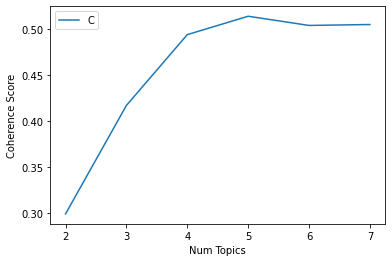

In [26]:
limit =8
start = 2
step=1
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence Score")
plt.legend(("Coherence_Values"), loc = "best")
plt.show()

In [27]:
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, "has Coherence value of", round(cv,4))

Num Topics = 2 has Coherence value of 0.299
Num Topics = 3 has Coherence value of 0.417
Num Topics = 4 has Coherence value of 0.494
Num Topics = 5 has Coherence value of 0.514
Num Topics = 6 has Coherence value of 0.504
Num Topics = 7 has Coherence value of 0.505


In [28]:
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted = False)
pprint(optimal_model.print_topics(num_words = 10))

[(0,
  '0.020*"company" + 0.016*"sale" + 0.013*"firm" + 0.013*"share" + '
  '0.013*"year" + 0.010*"profit" + 0.008*"dollar" + 0.008*"market" + '
  '0.007*"deal" + 0.006*"business"'),
 (1,
  '0.009*"people" + 0.009*"government" + 0.008*"labour" + 0.007*"tell" + '
  '0.007*"party" + 0.006*"plan" + 0.006*"election" + 0.006*"issue" + '
  '0.005*"claim" + 0.005*"law"'),
 (2,
  '0.025*"film" + 0.014*"year" + 0.012*"music" + 0.010*"award" + '
  '0.009*"include" + 0.008*"star" + 0.007*"tv" + 0.007*"director" + '
  '0.006*"top" + 0.006*"dance"'),
 (3,
  '0.015*"game" + 0.010*"play" + 0.009*"time" + 0.009*"people" + '
  '0.008*"player" + 0.008*"year" + 0.006*"technology" + 0.006*"win" + '
  '0.005*"set" + 0.005*"good"'),
 (4,
  '0.018*"year" + 0.014*"rise" + 0.009*"figure" + 0.008*"government" + '
  '0.008*"expect" + 0.007*"increase" + 0.007*"fall" + 0.007*"cost" + '
  '0.007*"high" + 0.007*"economic"')]


In [29]:
x = optimal_model.show_topics(num_topics = 5, num_words = 10, formatted = False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]])for tp in x]

In [30]:
for topic, words in topics_words:
    print(str(topic),"::", str(words))

0 :: ['company', 'sale', 'firm', 'share', 'year', 'profit', 'dollar', 'market', 'deal', 'business']
1 :: ['people', 'government', 'labour', 'tell', 'party', 'plan', 'election', 'issue', 'claim', 'law']
2 :: ['film', 'year', 'music', 'award', 'include', 'star', 'tv', 'director', 'top', 'dance']
3 :: ['game', 'play', 'time', 'people', 'player', 'year', 'technology', 'win', 'set', 'good']
4 :: ['year', 'rise', 'figure', 'government', 'expect', 'increase', 'fall', 'cost', 'high', 'economic']


## Word Clouds of Top N Keywords in Each Topic

word cloud with the size of the words proportional to the weight is a pleasant sight.

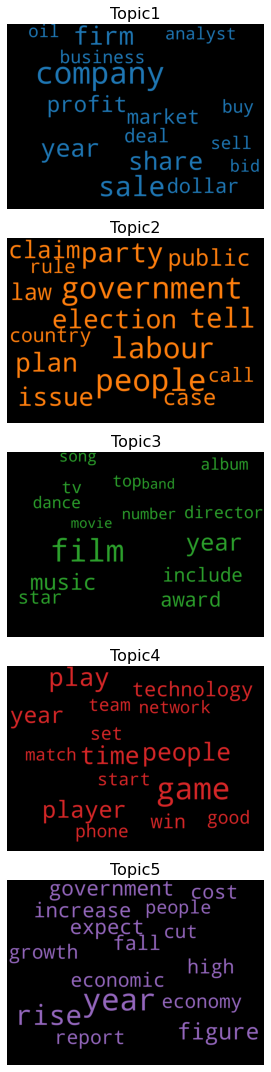

In [31]:
total_words = 15
cols = [color for name, color in mcolors.TABLEAU_COLORS. items()]
cloud = WordCloud(stopwords = stop_words,
                  background_color = "black",
                  width = 2500,
                  height = 1800,
                  max_words = total_words,
                  colormap = "tab10",
                  color_func = lambda*args, **kwargs: cols[i],
                  prefer_horizontal = 1.0)
topics = optimal_model.show_topics(formatted= False, num_words = total_words)
fig, ax = plt.subplots(nrows = 5, ncols = 1, figsize = (30,15), sharex = True, sharey = True)

for i,j in enumerate(ax.flatten()):
    fig.add_subplot(j)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title("Topic"+str(i+1), fontdict = dict(size = 16))
    plt.gca().axis("off")

plt.subplots_adjust(wspace = 0.9, hspace = 0)
plt.axis("off")
plt.margins(x = 0, y = 0)
plt.tight_layout()
plt.show()
    

## Word Counts of Topic Keywords

When it comes to the keywords in the topics, the importance (weights) of the keywords matters. Along with that, how frequently the words have appeared in the documents is also interesting to look.
Let’s plot the word counts and the weights of each keyword in the same chart.

You want to keep an eye out on the words that occur in multiple topics and the ones whose relative frequency is more than the weight. Often such words turn out to be less important. The chart I’ve drawn below is a result of adding several such words to the stop words list in the beginning and re-running the training process.

In [32]:
data_flat = [w for w_list in data_lemmatized for w in w_list]
count = Counter(data_flat)
out = []
for id, topic in topics:
    for word, weight in topic:
        out.append([word, id, weight, count[word]])
df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        
df.head(10)

,word,topic_id,importance,word_count
0,company,0,0.019892,1018
1,sale,0,0.016062,614
2,firm,0,0.012963,825
3,share,0,0.012889,519
4,year,0,0.012706,2958
5,profit,0,0.009950,287
6,dollar,0,0.008239,224
7,market,0,0.008189,683
8,deal,0,0.007161,486
9,business,0,0.006297,436


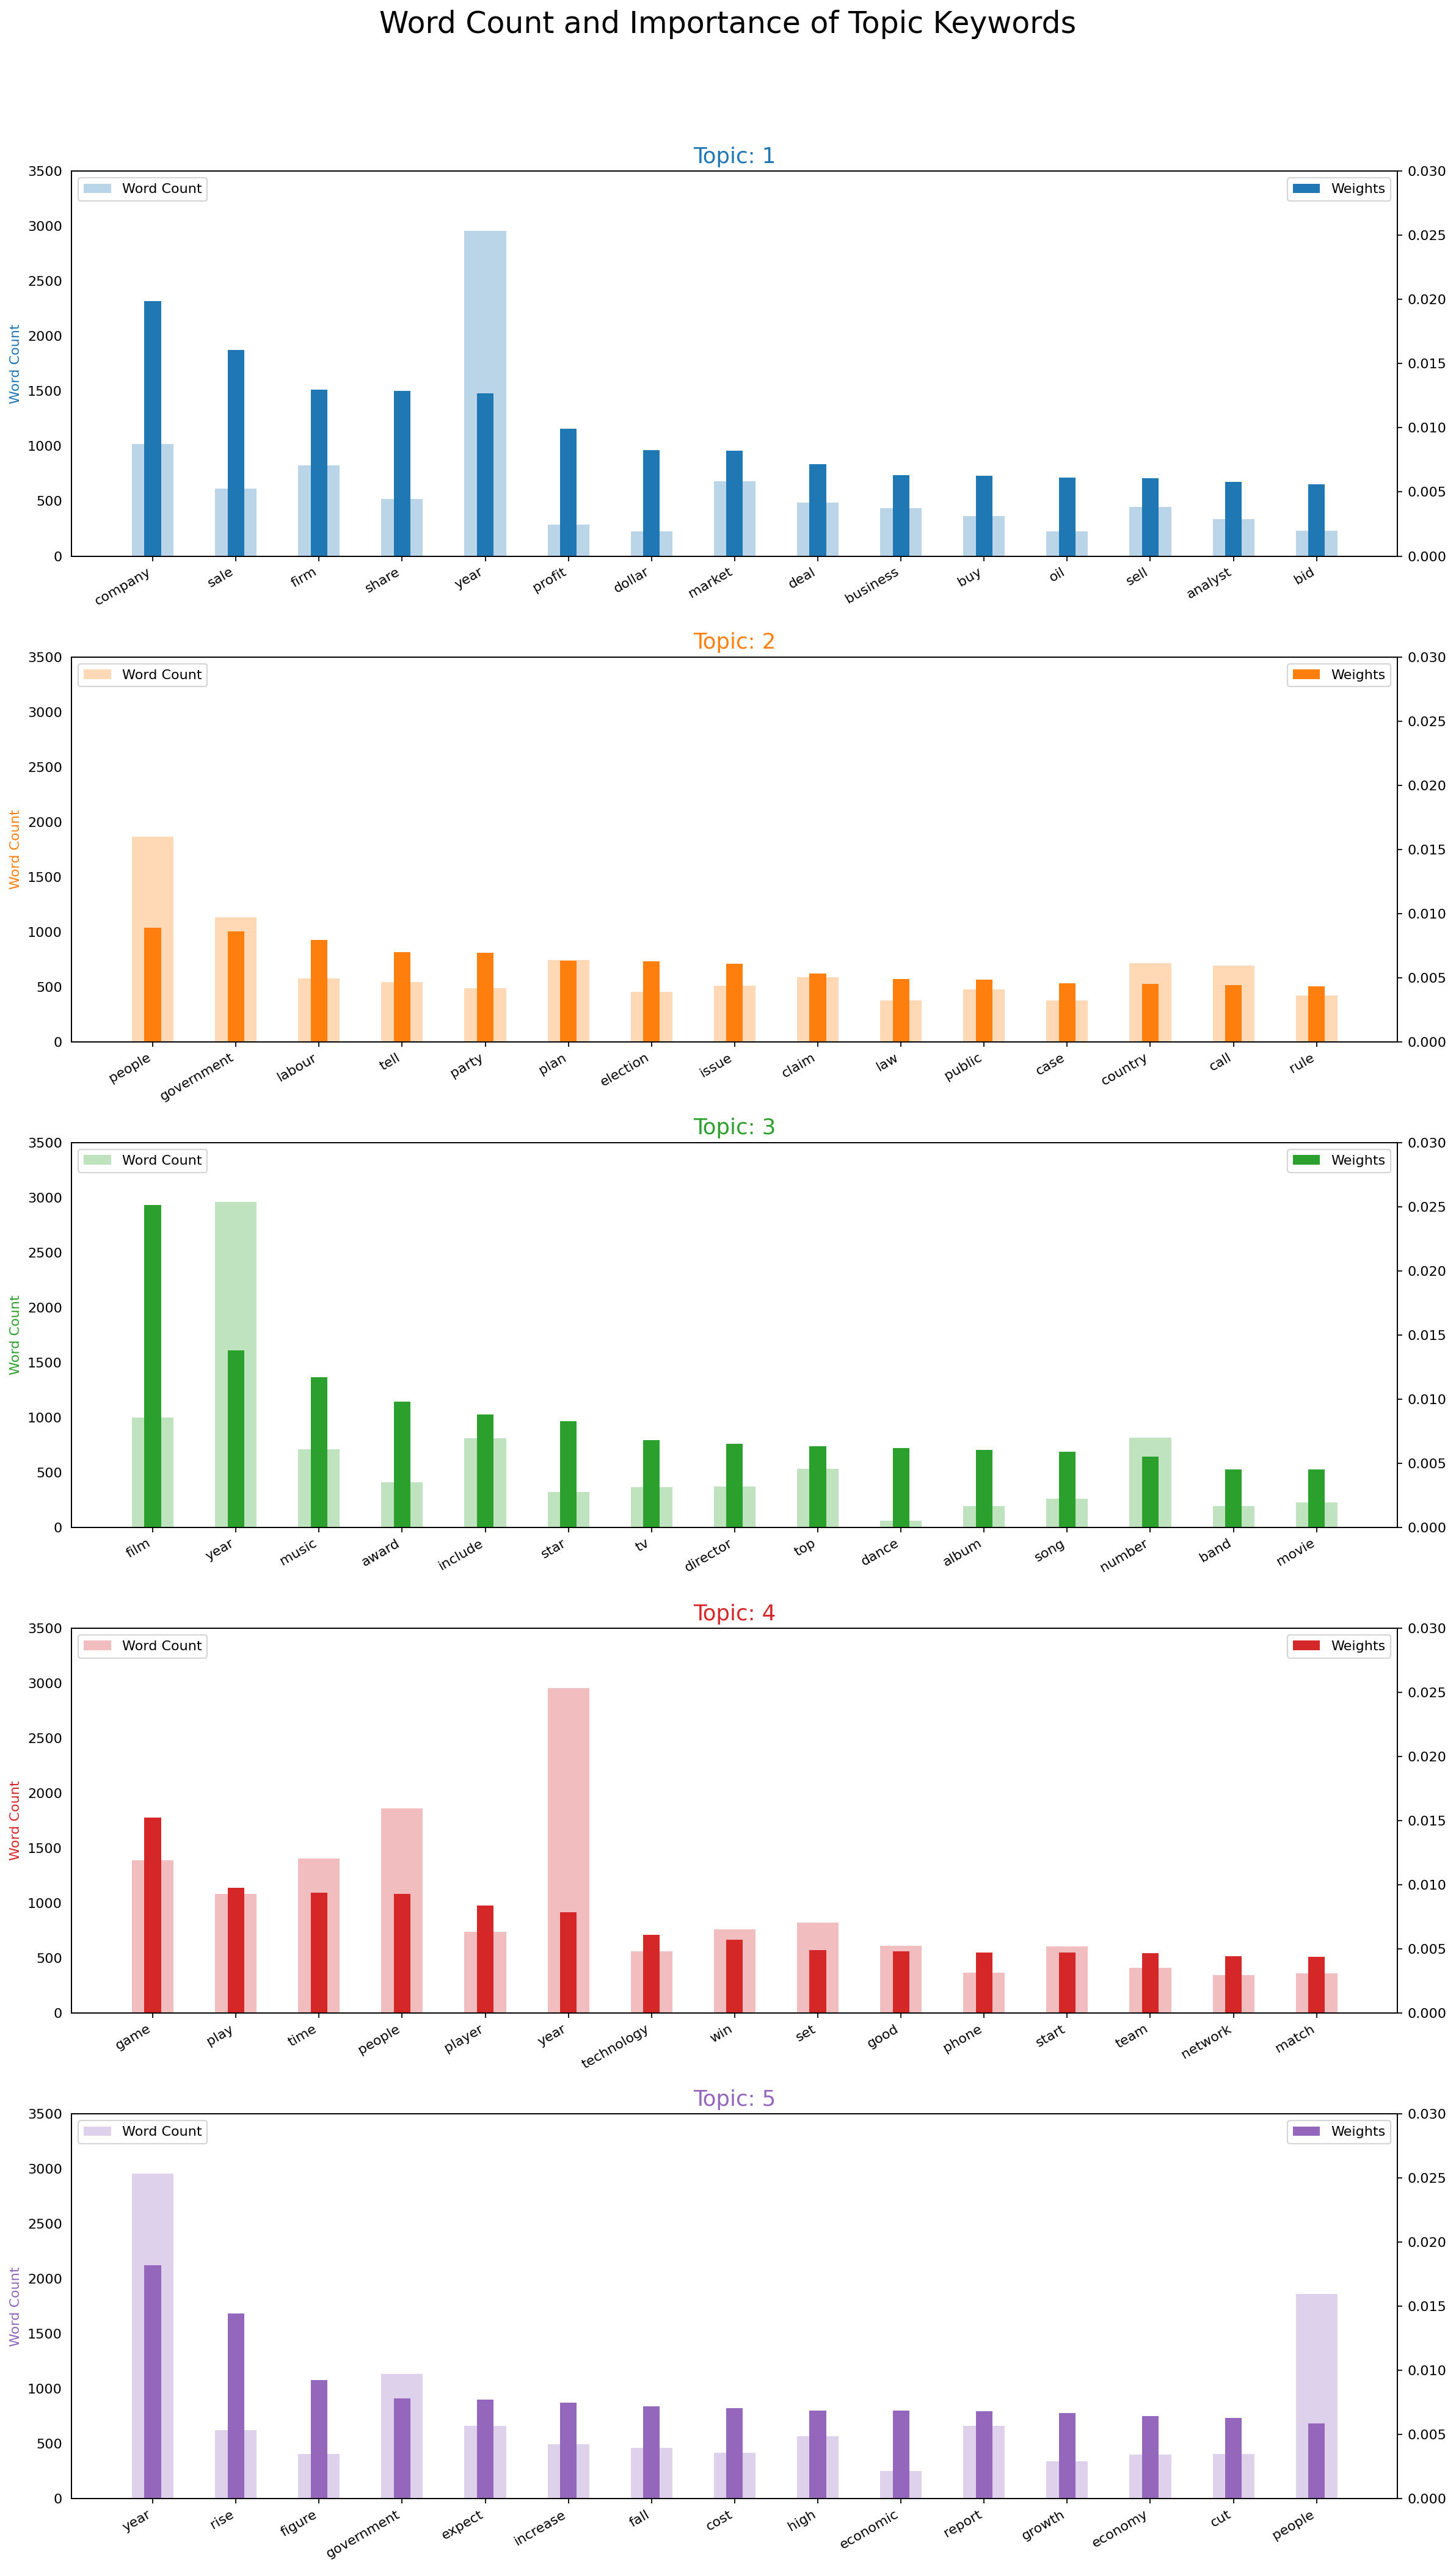

In [33]:
fig, axes = plt.subplots(5, 1, figsize=(15,25), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df[df.topic_id==i], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df[df.topic_id==i], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i+1), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

## Sentence Chart Colored by Topic

Each word in the document is representative of one of the 5 topics. Let’s color each word in the given documents by the topic id it is attributed to.
The color of the enclosing rectangle is the topic assigned to the document.

In [69]:
def sentences_chart(lda_model, corpus, start, end):
    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95), dpi=160)       
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1] 
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
            word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)    
            ax.text(0.01, 0.5, "Doc " + str(i-1) + ": ", verticalalignment='center',
                    fontsize=16, color=mycolors[topic_percs_sorted[0][0]], 
                    transform=ax.transAxes, fontweight=700)           
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1, 
                                   color=mycolors[topic_percs_sorted[0][0]], linewidth=2))
            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < end-1:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment='left',
                            verticalalignment='center',
                            fontsize=16, color=mycolors[topics],
                            transform=ax.transAxes, fontweight=700)
                    word_pos += .009 * len(word)  # to move the word for the next iter
                    ax.axis('off')
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16, color='black',
                    transform=ax.transAxes)       

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end-2), fontsize=22, y=0.95, fontweight=700)
    plt.tight_layout()
    plt.show()

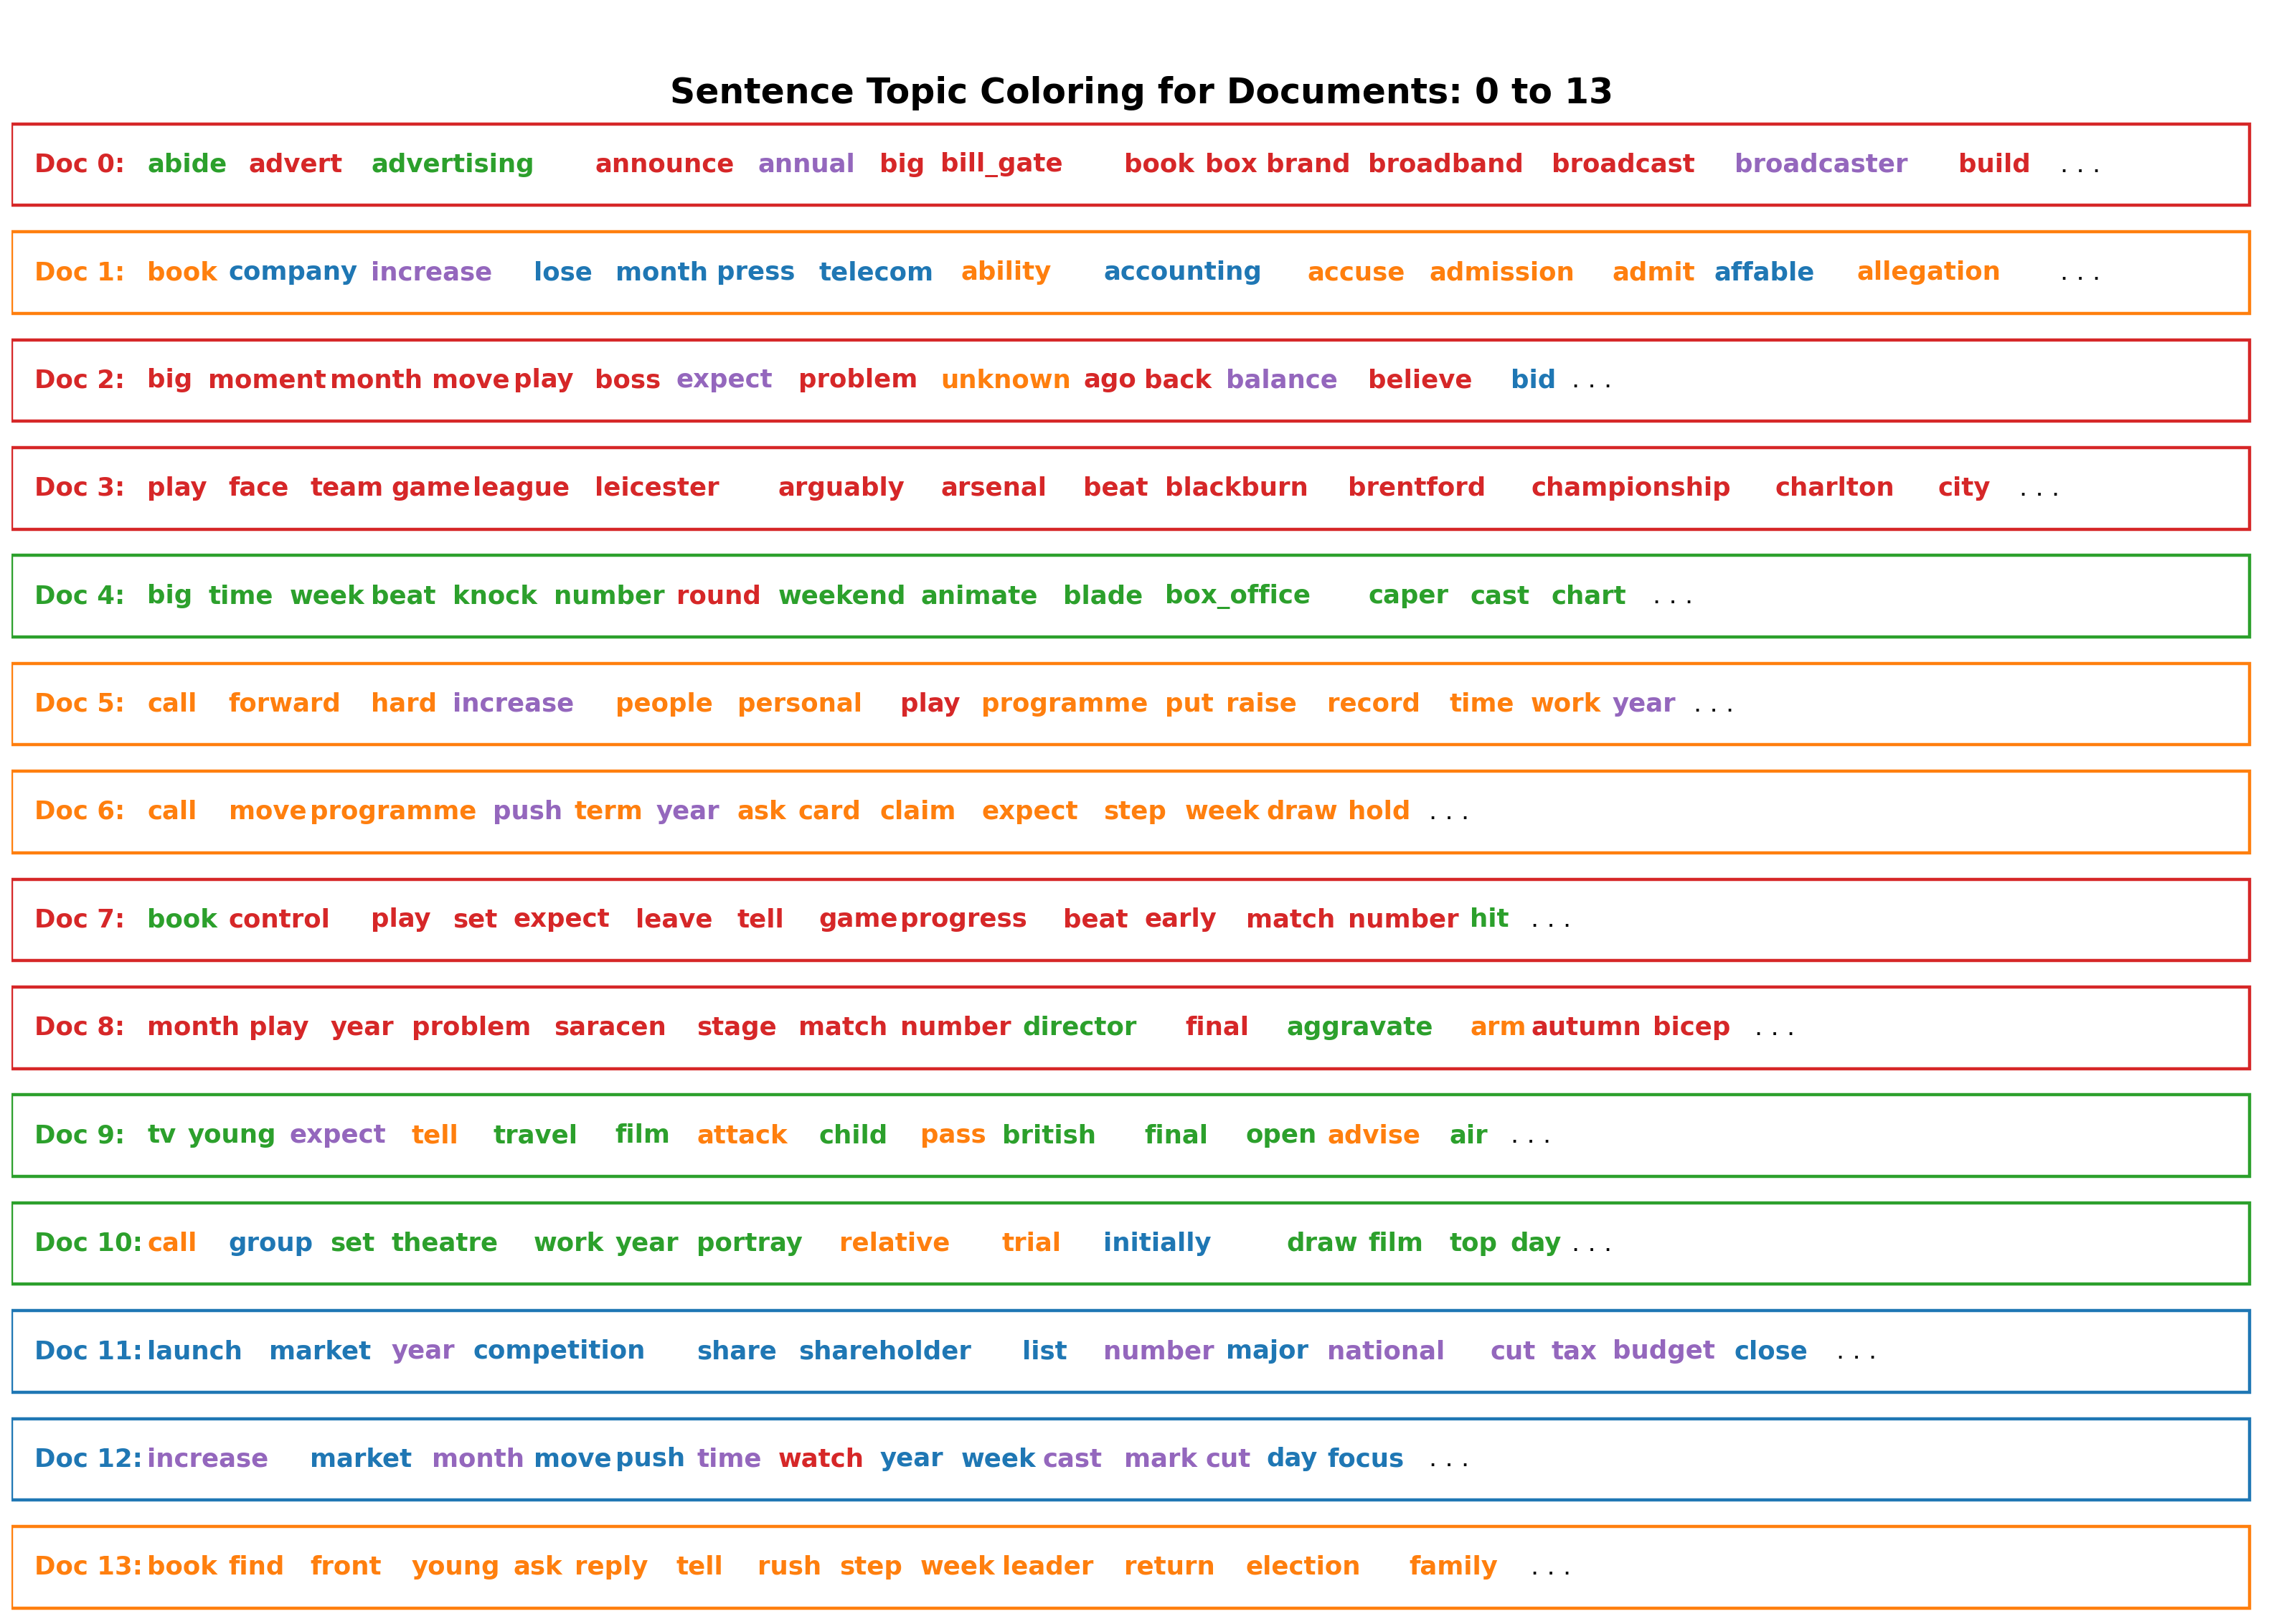

In [35]:
sentences_chart(lda_model=optimal_model, corpus=corpus, start = 0, end = 15)    

 ## What are the most discussed topics in the documents?

compute the total number of documents attributed to each topic.

In [54]:
def topics_per_document(model, corpus, start = 0, end = 1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i,corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return (dominant_topics, topic_percentages) 

In [61]:
dominant_topics, topic_percentages = topics_per_document(model = optimal_model, corpus = corpus, end = -1)
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby("Dominant_Topic").size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name = "count").reset_index()
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name = "count").reset_index()
topic_top3words = [(i, topic) for i, topics in optimal_model.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 4]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)

Let’s make two plots:

1. The number of documents for each topic by assigning the document to the topic that has the most weight in that document.
2. The number of documents for each topic by by summing up the actual weight contribution of each topic to respective documents.

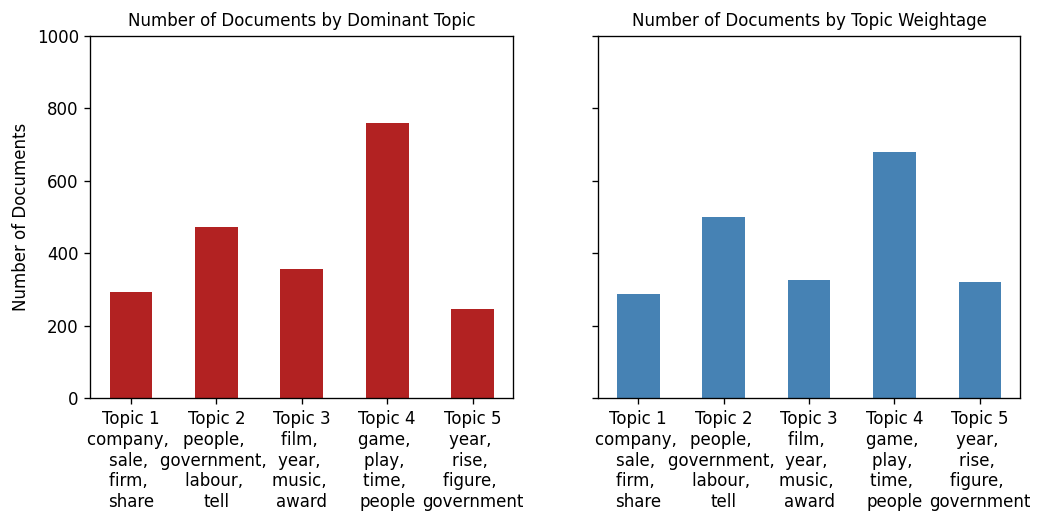

In [64]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=120, sharey=True)
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x+1)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 1000)
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))
plt.show()

## t-SNE Clustering Chart

Let’s visualize the clusters of documents in a 2D space using t-SNE (t-distributed stochastic neighbor embedding) algorithm.

In [67]:
topic_weights = []
for i, row_list in enumerate(optimal_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])   
arr = pd.DataFrame(topic_weights).fillna(0).values
arr = arr[np.amax(arr, axis=1) > 0.35]
topic_num = np.argmax(arr, axis=1)
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)
output_notebook()
n_topics = 4
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2093 samples in 0.002s...
[t-SNE] Computed neighbors for 2093 samples in 0.042s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2093
[t-SNE] Computed conditional probabilities for sample 2000 / 2093
[t-SNE] Computed conditional probabilities for sample 2093 / 2093
[t-SNE] Mean sigma: 0.042145
[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.177677
[t-SNE] KL divergence after 1000 iterations: 0.672270


## pyLDAvis

Finally, pyLDAVis is the most commonly used and a nice way to visualise the information contained in a topic model. Below is the implementation for LdaModel()

In [68]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(optimal_model, corpus, dictionary=optimal_model.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.098139 -0.038177       1        1  32.247640
1      0.081083 -0.233173       2        1  25.595564
4     -0.170589 -0.000287       3        1  16.041056
2      0.193481  0.195922       4        1  13.883373
0     -0.202114  0.075715       5        1  12.232368, topic_info=         Term         Freq        Total Category  logprob  loglift
374      film   973.000000   973.000000  Default  30.0000  30.0000
255      game  1370.000000  1370.000000  Default  29.0000  29.0000
27    company   875.000000   875.000000  Default  28.0000  28.0000
725      rise   688.000000   688.000000  Default  27.0000  27.0000
1139     sale   789.000000   789.000000  Default  26.0000  26.0000
...       ...          ...          ...      ...      ...      ...
760    report   168.889056   669.106087   Topic5  -5.3076   0.7244
1068     bank   127.834709   261.940199   Topic5  -5.5861   1.3837
191    expect   155.693959   747.608127   Topic5  -5.3890   0.5321
5         big   151.548926   707.692317   Topic5  -5.4159   0.5600
83       lose   128.125485   513.524616   Topic5  -5.5838   0.7128

[318 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
163       2  0.996058   accuse
955       4  0.992083    actor
1417      4  0.992266  actress
1155      2  0.991870   agency
909       5  0.991599      aid
...     ...       ...      ...
159       1  0.268569     year
159       2  0.055461     year
159       3  0.308835     year
159       4  0.202471     year
159       5  0.164484     year

[524 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 2, 5, 3, 1])